# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
batch_size = 10
color_mean = (0.5, 0.5, 0.5)
color_std = (0.5, 0.5, 0.5)

# Define transforms
train_data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(color_mean, color_std)])

test_data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(color_std, color_std)])

# Create training set and define training dataloader
trainset = torchvision.datasets.CIFAR10(root='./images', train = True, download = True,
                                       transform = train_data_transforms)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10(root='./images', train = False, download = True,
                                      transform = test_data_transforms)

testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader, image_mean = (0.5, 0.5, 0.5), image_std = (0.5, 0.5, 0.5)):
    
    dataiter = iter(img_loader)
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    
    fig, ax = plt.subplots(1, 5, figsize=(10, 2))
    
    for i in range(5):
        image = images[i].numpy()
        image = np.rot90(image.T, k=3)
        image = (image_std * image) + image_mean
        #print(np.shape(image))
        ax[i].imshow(image)
        ax[i].set_title(classes[labels[i]])

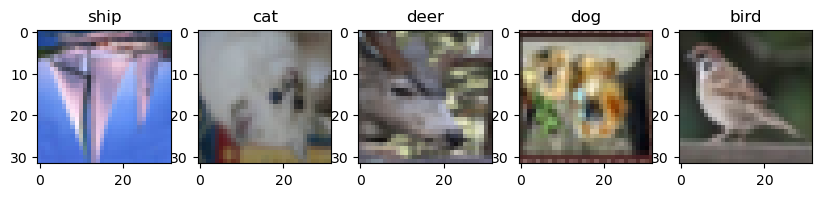

In [4]:
# Explore train data
show5(trainloader)

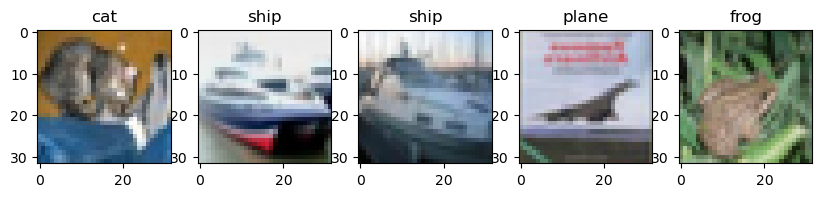

In [5]:
# Explore test data
show5(testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = torch.flatten(x, 1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

nn_img_classifier = NeuralNetwork()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_img_classifier.parameters(), lr = 0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [8]:
# set number of epoches for neuralnetwork training
epoches = 30
# train loss data
train_losses, test_losses = [], []
# select GPU as processing unit if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device\n'.format(device))
# move model to GPU or CPU
nn_img_classifier.to(device);

Using cpu device



### Model training and validation

In [9]:
# train model for the number of epoches
for epoch in range(epoches):
    
    running_loss = 0.0
    
    # training pass
    for images, labels in trainloader:
        
        # move computations to CPU or GPU if available
        images, labels = images.to(device), labels.to(device)
        
        # clear gradient
        optimizer.zero_grad()
        # compute nn output
        pred = nn_img_classifier(images)
        # get training loss
        loss = criterion(pred, labels)
        # compute gradient
        loss.backward()
        # convergence to the optimum
        optimizer.step()
        
        # keep track of running loss
        running_loss += loss.item()
    
    # validation pass
    else:
        test_loss = 0
        accuracy = 0
        
        # pass forward on validation set
        with torch.no_grad():
            # set model to evaluation mode
            nn_img_classifier.eval()
            for images, labels in testloader:
                
                # move computations to CPU or GPU if available
                images, labels = images.to(device), labels.to(device)
                
                # compute nn output
                pred = nn_img_classifier(images)
                # get testing loss
                test_loss += criterion(pred, labels)
                
                probabilities = torch.exp(pred)
                top_p, top_class = probabilities.topk(1, dim=1)
                matches = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(matches.type(torch.FloatTensor))
            
            # set model back to training mode 
            nn_img_classifier.train()

        # save loss data
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print('Epoch: {}/{};'.format(epoch + 1, epoches),
              'Training loss: {:.3f};'.format(running_loss/len(trainloader)),
              'Test Loass: {:.3f};'.format(test_loss/len(testloader)),
              'Test Accuracy: {:.1f} %'.format((accuracy/len(testloader)) * 100))

print('Training done!')

Epoch: 1/30; Training loss: 1.714; Test Loass: 1.507; Test Accuracy: 44.6 %
Epoch: 2/30; Training loss: 1.478; Test Loass: 1.446; Test Accuracy: 47.4 %
Epoch: 3/30; Training loss: 1.405; Test Loass: 1.332; Test Accuracy: 51.8 %
Epoch: 4/30; Training loss: 1.352; Test Loass: 1.336; Test Accuracy: 51.7 %
Epoch: 5/30; Training loss: 1.311; Test Loass: 1.263; Test Accuracy: 55.0 %
Epoch: 6/30; Training loss: 1.283; Test Loass: 1.213; Test Accuracy: 57.3 %
Epoch: 7/30; Training loss: 1.260; Test Loass: 1.250; Test Accuracy: 55.6 %
Epoch: 8/30; Training loss: 1.238; Test Loass: 1.232; Test Accuracy: 56.4 %
Epoch: 9/30; Training loss: 1.215; Test Loass: 1.245; Test Accuracy: 56.1 %
Epoch: 10/30; Training loss: 1.206; Test Loass: 1.168; Test Accuracy: 59.5 %
Epoch: 11/30; Training loss: 1.186; Test Loass: 1.192; Test Accuracy: 58.5 %
Epoch: 12/30; Training loss: 1.178; Test Loass: 1.152; Test Accuracy: 59.8 %
Epoch: 13/30; Training loss: 1.166; Test Loass: 1.149; Test Accuracy: 59.6 %
Epoch: 1

Plot the training loss (and validation loss/accuracy, if recorded).

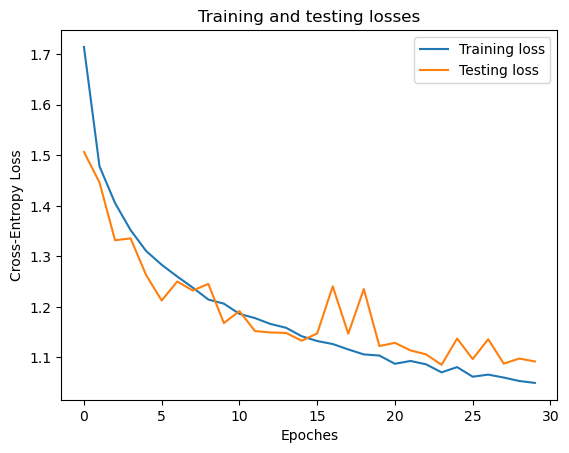

In [10]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='Training loss')
ax.plot(test_losses, label = 'Testing loss')
plt.title('Training and testing losses')
plt.xlabel('Epoches')
plt.ylabel('Cross-Entropy Loss')
ax.legend()
plt.show()

### Inspect results

In [11]:
def show_image(img_loader,
               image_mean = (0.5, 0.5, 0.5),
               image_std = (0.5, 0.5, 0.5)):
    
    next_image = next(iter(img_loader))
     
    label = next_image[1][0]
    tensor_image = next_image[0][0]
    image = tensor_image.numpy()
    
    fig, ax = plt.subplots(1, figsize=(2, 2))
    
    image = np.rot90(image.T, k=3)
    image = (image_std * image) + image_mean
    label = classes[label]
    ax.imshow(image)
    ax.set_title(label)
    return (label, tensor_image)

In [48]:
def predict_image_object(model, image):
    # adjust tensor dimentions
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        # set model to evaluation mode
        model.eval()
        # move computation to CPU or GPU
        image = image.to(device)
        # compute nn output
        pred = model(image)
        # compute probabilities
        probabilities = torch.exp(pred)
    # compute top probabilities and classes 
    top_p, top_class = torch.topk(probabilities, k = 1)
    return({'probability': float(top_p),
            'class': int(top_class)})

There is a plane in the picture with probability: 93.14 %


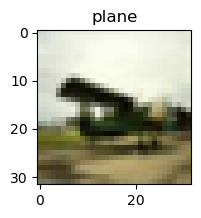

In [79]:
test_image = show_image(trainloader)
prob_class  = predict_image_object(nn_img_classifier, test_image[1])
print('There is a {} in the picture with probability: {:.2f} %'\
      .format(classes[prob_class['class']], prob_class['probability']*100))
#print(prob_class)

## Saving your model
Using `torch.save`, save your model for future loading.

In [65]:
path = os.path.join(os.getcwd(), 'model.pth')
torch.save(nn_img_classifier, path)
print('Model saved under path: {}'.format(path))

Model saved under path: /Users/tomaszkowalski/Documents/LearningNewThings/Intro-to-Machine-Learning-with-Pytorch/CIFAR-10_Image_Classifier/model.pth


## Make a Recommendation

Q: Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

A: To answer this question one would have to compare the cost of buying a trained model to the cost and time of developing one's own model. It seems that the purchase of a pre-trained model would be more beneficial. 


Some things to consider as you formulate your recommendation:

Q: How does your model compare to Detectocorp's model?

A: The model is not as good as Detectocorp. The accuracy of the model on the test set reaches 62% compared with the Detectocorp model which reaches an accuracy of 70%. 

Q: How does it compare to the far more advanced solutions in the literature?

A: The model's performance is significantly lower than models known in the literature. The development of accurate classifiers has taken years and is further the object of research to improve them

Q: What did you do to get the accuracy you achieved? 

A:
* Applied various transformations on the training dataset
* Training for 30 epoches
* Two convolution layers were used in the model
* Dropuot and softmax functions used in the classifier

Q: Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

A: Accuracy of 62% is currently not satisfactory compared to neural classifiers known in the literature. Improvements should be implemented:

* Changing the architecture of the model
* Transfer learning
* Increasing the number training of epoches


## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).